# Winrate Simulation

In [1]:
import pandas as pd
import sqlite3
import numpy as np
main_db = sqlite3.connect(r'/Users/amberlights/Repositories/simple-lol-stats/sqlite_database/project_database.db')
cursor = main_db.cursor()

In [2]:
winrate_fromapi = pd.read_sql_query('''
SELECT c.name as champion, ROUND(AVG(w.have_won), 4) AS winrate, count(w.champion) as matches
FROM winrate_data w
LEFT JOIN champions c
ON w.champion = c.id
WHERE champion is not null
GROUP BY c.name;
''', main_db
)

players = pd.read_sql('''
SELECT role, champion
FROM champion_pool
''', main_db
)

df_players = pd.DataFrame(players)
df_winrate = pd.DataFrame(winrate_fromapi)

In [3]:
df = pd.merge(df_players, df_winrate, on='champion', how='left')
df['winrate'] = df['winrate']*100

In [4]:
df

,role,champion,winrate,matches
0,jungler,Lillia,21.71,737
1,jungler,Volibear,51.41,817
2,jungler,Sejuani,49.81,269
3,jungler,Poppy,53.10,403
4,jungler,Ekko,49.91,587
5,jungler,Hecarim,51.64,730
6,adc,Samira,45.21,553
7,adc,Jinx,50.44,2034
8,adc,Draven,47.77,785
9,adc,Sivir,52.59,521


In [5]:
def calculate_proportions(df):
    role_groups = df.groupby('role')
    result_frames = []

    for role, group in role_groups:
        total_matches = group['matches'].sum()
        group['proportion'] = group['matches'] / total_matches
        group['theoretical_games'] = (group['proportion'] * 1000).round().astype(int)
        result_frames.append(group)

    return pd.concat(result_frames)

df = calculate_proportions(df)

In [6]:
def simulate_games_with_numpy(df):
    rng = np.random.default_rng()
    iteration_results = []

    for i in range(1000):
        iteration_winrates = []

        for _, role_group in df.groupby('role'):
            results = []
            for _, row in role_group.iterrows():
                games = row['theoretical_games']
                winrate = row['winrate'] / 100
                outcomes = rng.choice([1, 0], size=games, p=[winrate, 1 - winrate])
                results.extend(outcomes)

            avg_winrate = np.mean(results)
            iteration_winrates.append({'role': role_group['role'].iloc[0], 'winrate': avg_winrate * 100})

        iteration_results.extend(iteration_winrates)

    return pd.DataFrame(iteration_results)

simulation_df = simulate_games_with_numpy(df)

/var/folders/9m/rglxw5bd15g0669_6zc63m000000gn/T/ipykernel_8508/2179282912.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=simulation_df, x='winrate', y='role', palette='crest', showfliers = False)


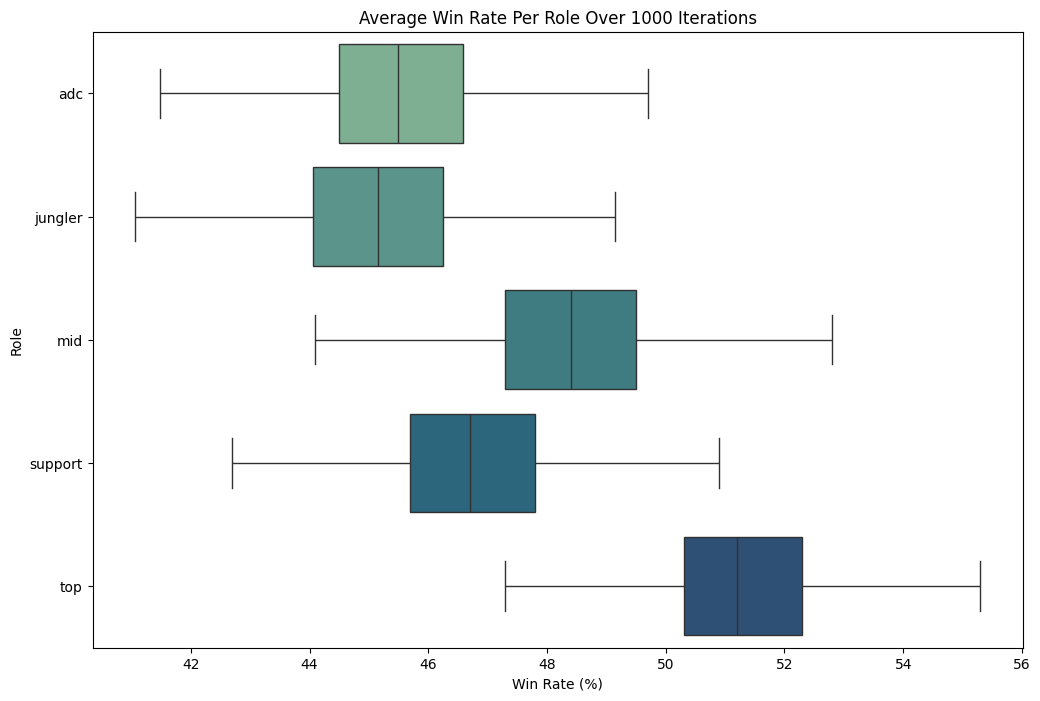

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 8))
sns.boxplot(data=simulation_df, x='winrate', y='role', palette='crest', showfliers = False)
plt.title('Average Win Rate Per Role Over 1000 Iterations')
plt.xlabel('Win Rate (%)')
plt.ylabel('Role')
plt.show()